# 3교시 대비: 이상탐지(불량/고장) **지도+비지도 결합** 완전체 템플릿 (토이데이터 + 문제 + 모범답안 + 실무 해설)

이 노트북은 3교시 공식 평가 목적에 맞춰, **이상탐지(이진 분류)** 유형에서  
**시험장에서 "복붙 후 컬럼명만 바꾸면" 바로 적용**할 수 있게 만든 템플릿입니다.

## 🎯 평가 목적(공식)
- 실제 산업 데이터를 기반으로 **이상 탐지** 수행
- **데이터 불균형**, **모델 해석**, **지표 최적화(임계값 정책)** 를 통해 실무형 역량 검증

---

## ✅ 이 노트북이 제공하는 것
- (A) **지도학습**: Logistic / RF / XGB(가능 시) → `predict_proba` 기반 위험도(score)
- (B) **비지도학습**: IsolationForest / PCA(SVD) 재구성오차(안전) + (옵션) AutoEncoder
- (C) **결합 전략**:
  1) 비지도 score를 **추가 피처로 넣어** 지도모델 성능 강화  
  2) 지도 확률 + 비지도 score를 **앙상블 스코어**로 결합
- (D) **임계값 정책**(운영/현장 적용):
  - F1 최적 threshold
  - Top N%(예: Top 5%) 정책
  - Recall 고정(예: Recall ≥ 0.90) 정책
- (E) **리포트 출력**: Top-N 이상 샘플 테이블
- (F) **실무 해설(모든 경우의 수에 가까운 가이드)**:
  - 데이터가 어떻다면 어떤 전처리/기법이 유리한지
  - 불균형이 심하면 무엇을 바꾸는지
  - 임계값이 마음에 안 들면 무엇을 조정하는지
  - 모델이 과적합/성능부진이면 무엇을 추가하는지

> 시험장에서 할 일: `CSV_PATH`, `target_col`, `cat_cols`만 바꾸면 대부분 그대로 동작합니다.


## 0) Imports & 재현성

In [1]:
import os, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score, precision_score, recall_score
)

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest

# XGBoost는 환경에 따라 있을 수도/없을 수도 있음
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## 1) 토이데이터 생성 (시험장에서는 CSV 로딩으로 대체)

### 데이터 컨셉(기출과 유사)
- 배치(batch) 단위 제조/설비 데이터
- 범주형: line/shift/supplier/material
- 수치형: 온도/압력/진동/사이클/에러 등
- 타깃: `eol_fail` (0 정상, 1 불량)

### 포함된 “시험 단골 요소”
- **클래스 불균형**(불량 2~5%)
- 결측치
- 이상치(outlier)
- 일부 변수에만 약하게 나타나는 “미세 이상 신호”


In [2]:
def make_toy_anomaly(n=20000, pos_ratio=0.04, seed=42):
    rng = np.random.default_rng(seed)

    # 범주형
    line_id = rng.integers(1, 7, size=n).astype(str)   # 1~6
    shift = rng.choice(["day", "swing", "night"], size=n, p=[0.5, 0.3, 0.2])
    supplier = rng.choice(["A","B","C","D","E"], size=n, p=[0.25,0.25,0.2,0.2,0.1])
    material_grade = rng.choice(["G1","G2","G3"], size=n, p=[0.55,0.35,0.10])

    # 수치형(정상 분포)
    temp_mean = rng.normal(70, 5, size=n) + (line_id.astype(int)-3)*0.7
    pressure_std = np.abs(rng.normal(1.1, 0.35, size=n))
    vibration_max = np.abs(rng.normal(3.0, 1.0, size=n)) + (shift=="night")*0.6
    humidity = np.clip(rng.normal(45, 10, size=n), 10, 90)
    cycle_time = rng.normal(120, 15, size=n) + (material_grade=="G3")*7
    error_cnt = rng.poisson(1.3, size=n) + (supplier=="E")*1

    # 불량 라벨 생성: 희귀 + 약한 신호(일부 조합에서 상승)
    # 점수로 "불량 위험"을 만든 뒤 상위 pos_ratio만 1로 지정
    risk = (
        0.9*np.maximum(0, vibration_max-3.5)
        + 1.2*np.maximum(0, error_cnt-2)
        + 0.03*np.maximum(0, cycle_time-130)
        + (supplier=="E")*0.7
        + (material_grade=="G3")*0.8
        + ((supplier=="C") & (shift=="night"))*0.6
        + rng.normal(0, 0.3, size=n)
    )

    # 상위 pos_ratio를 불량으로 라벨링
    thr = np.quantile(risk, 1 - pos_ratio)
    y = (risk >= thr).astype(int)

    df = pd.DataFrame({
        "line_id": line_id,
        "shift": shift,
        "supplier": supplier,
        "material_grade": material_grade,
        "temp_mean": temp_mean,
        "pressure_std": pressure_std,
        "vibration_max": vibration_max,
        "humidity": humidity,
        "cycle_time": cycle_time,
        "error_cnt": error_cnt,
        "eol_fail": y
    })

    # 결측치 주입(약 2%)
    for col in ["temp_mean","pressure_std","humidity"]:
        mask = rng.random(n) < 0.02
        df.loc[mask, col] = np.nan

    # 이상치 주입(약 0.5%)
    out_mask = rng.random(n) < 0.005
    df.loc[out_mask, "vibration_max"] *= 5
    df.loc[out_mask, "error_cnt"] += 15

    return df

df = make_toy_anomaly()
df.head()


,line_id,shift,supplier,material_grade,temp_mean,pressure_std,vibration_max,humidity,cycle_time,error_cnt,eol_fail
0,1,swing,B,G2,73.168503,0.876834,4.762998,36.643940,113.076839,2,0
1,5,swing,B,G1,59.481520,1.511594,3.343818,49.100940,148.367302,3,0
2,4,day,E,G2,68.842233,0.781406,2.808230,49.216298,111.936949,2,0
3,3,day,A,G1,67.952355,1.244450,2.125842,38.328802,103.403071,3,0
4,3,day,A,G1,67.677732,0.856918,3.649270,44.314638,127.155881,0,0


## 2) (시험형) 문제 정의 — 이상탐지(불량) 프로젝트

### 배경(예시)
제조 라인에서는 공정 변수(설비/품질/환경)의 미세 이상이 누적되어 최종 불량(EOL Fail)이 발생한다.  
주어진 데이터는 배치 단위 공정 특성치이며, 타깃 `eol_fail`은 불량 여부(0 정상, 1 불량)이다.

### 목표
- 지도 + 비지도 학습을 결합하여 **불량 위험도(score)** 를 산출
- 운영 현장에 적용 가능한 **임계값 정책(Threshold Policy)** 을 제시하고 비교

### 요구사항(기출 스타일)
1) 데이터 크기와 클래스 비율을 출력하고 불균형 여부를 확인하라.  
2) 범주형/수치형 전처리를 수행하고 결측/이상치/불균형 대응을 포함하라.  
3) 분류 모델을 학습하고 적절한 지표(PR-AUC/F1 등)로 평가하라.  
4) 임계값 정책 2개 이상을 비교하라. (예: F1-opt vs Top 5% vs Recall 고정)  
5) Top-N 이상 샘플 리포트를 출력하라.  
6) (가산) 모델 해석(피처 중요도/SHAP 등)을 제시하라.


## 3) 1번: 데이터 탐색(불균형 확인)

Shape: (20000, 11)

Target counts:
eol_fail
0    19200
1      800
Name: count, dtype: int64

Target ratio:
eol_fail
0    0.96
1    0.04
Name: proportion, dtype: float64

Missing ratio(top):
pressure_std      0.01970
temp_mean         0.01925
humidity          0.01880
supplier          0.00000
shift             0.00000
line_id           0.00000
material_grade    0.00000
vibration_max     0.00000
cycle_time        0.00000
error_cnt         0.00000
dtype: float64


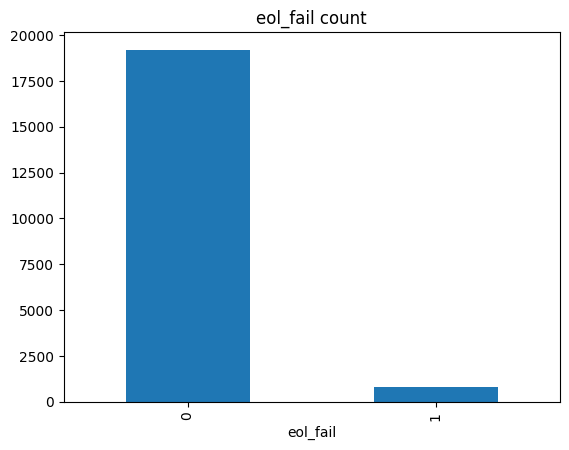

In [3]:
target_col = "eol_fail"
cat_cols = ["line_id", "shift", "supplier", "material_grade"]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]

print("Shape:", df.shape)
print("\nTarget counts:")
print(df[target_col].value_counts())
print("\nTarget ratio:")
print(df[target_col].value_counts(normalize=True))

print("\nMissing ratio(top):")
print(df.isna().mean().sort_values(ascending=False).head(10))

plt.figure()
df[target_col].value_counts().plot(kind="bar", title="eol_fail count")
plt.show()


### 💡 실무 해설(EDA에서 무엇을 보고 무엇을 결정?)
- **불량 비율이 10% 이하**면 불균형으로 보고, Accuracy 중심 평가는 피함 → **F1 / PR-AUC** 추천
- **결측이 특정 컬럼에 몰려 있으면**: 그 컬럼이 센서 장애/라인 특성일 수 있어, 삭제보다 **대체+결측 flag** 고려
- **이상치가 자주 보이면**: 스케일러를 `RobustScaler`로 바꾸거나, 로그 변환/클리핑 고려


## 4) Train/Validation split (stratify 필수)

In [4]:
X = df[cat_cols + num_cols].copy()
y = df[target_col].astype(int).copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Train pos ratio:", y_train.mean(), "Val pos ratio:", y_val.mean())


Train: (16000, 10) Val: (4000, 10)
Train pos ratio: 0.04 Val pos ratio: 0.04


## 5) 2번: 전처리(범주형/수치형) + 불균형 대응 준비

### 전처리 선택 가이드(시험장에서 데이터 보고 고르기)
- 수치형에 극단값이 많아 보이면 → `RobustScaler`
- 수치형 분포가 깔끔하면 → `StandardScaler`
- 트리 모델만 쓸 거면 스케일링이 필수는 아니지만, **비지도(SVD/PCA/AE)** 를 할 계획이면 스케일링이 도움

아래 스위치로 선택합니다.


In [5]:
USE_ROBUST = True   # 이상치 많으면 True
num_scaler = RobustScaler() if USE_ROBUST else StandardScaler()

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", num_scaler)
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols)
    ]
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc = preprocess.transform(X_val)

print("Encoded shapes:", X_train_enc.shape, X_val_enc.shape)


Encoded shapes: (16000, 23) (4000, 23)


## 6) 2번(확장): 비지도 학습으로 anomaly score/latent 생성

### 왜 비지도 score를 쓰나?
- 라벨이 희귀(불균형)할수록 지도 학습만으로는 신호가 약해질 수 있음  
- 비지도 score는 “정상 패턴에서 얼마나 벗어났는지”를 나타내는 **추가 신호**가 됨  
- 시험에서 '지도+비지도 결합'을 요구할 때 가장 깔끔한 답

여기서는 안정성 우선으로 아래 2가지를 제공합니다.
1) **IsolationForest score** (빠르고 간단)  
2) **TruncatedSVD 기반 재구성오차** (희소행렬에서도 안정)

> (옵션) AutoEncoder는 시간이 남을 때만. (다음 섹션에 옵션 제공)


In [6]:
# 6-A) Isolation Forest (비지도 anomaly score)
# 스케일된 수치형만으로도 가능하지만, 여기서는 전처리된 전체 특성에 적용(희소 가능)
iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=SEED,
    n_jobs=-1
)

# IsolationForest는 sparse 지원이 제한적일 수 있어, 안정성을 위해 dense로 변환할지 옵션 제공
DENSE_FOR_ISO = False  # 메모리 여유 있으면 True
X_train_iso = X_train_enc.toarray() if (DENSE_FOR_ISO and hasattr(X_train_enc, "toarray")) else X_train_enc
X_val_iso = X_val_enc.toarray() if (DENSE_FOR_ISO and hasattr(X_val_enc, "toarray")) else X_val_enc

iso.fit(X_train_iso)

# score_samples: 값이 클수록 "정상"에 가깝다. 이상 score로 쓰려면 부호 반전이 보통 편함.
iso_train_score = -iso.score_samples(X_train_iso)
iso_val_score = -iso.score_samples(X_val_iso)

print("iso score (val) summary:", np.min(iso_val_score), np.mean(iso_val_score), np.max(iso_val_score))


iso score (val) summary: 0.43792492126389126 0.4977677408619576 0.6250462595547805


In [7]:
# 6-B) TruncatedSVD latent + 재구성오차(reconstruction error)
# 희소행렬에서 PCA 대신 쓰는 안정적 선택
svd_dim = 12
svd = TruncatedSVD(n_components=svd_dim, random_state=SEED)
Z_train = svd.fit_transform(X_train_enc)
Z_val = svd.transform(X_val_enc)

# 재구성(근사)
X_train_recon = Z_train @ svd.components_
X_val_recon = Z_val @ svd.components_

# 재구성오차 (큰 값일수록 정상 패턴에서 벗어남)
# sparse를 dense로 계산하므로 메모리 고려: 샘플이 너무 크면 batch로 계산하는 방식이 필요할 수 있음.
X_train_dense = X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else np.asarray(X_train_enc)
X_val_dense = X_val_enc.toarray() if hasattr(X_val_enc, "toarray") else np.asarray(X_val_enc)

svd_train_score = np.mean((X_train_dense - X_train_recon)**2, axis=1)
svd_val_score = np.mean((X_val_dense - X_val_recon)**2, axis=1)

print("svd recon err (val) summary:", np.min(svd_val_score), np.mean(svd_val_score), np.max(svd_val_score))


svd recon err (val) summary: 0.022813662052460888 0.05472904219080472 0.13995310187548957


## 7) 지도+비지도 결합 전략

### 결합 전략 1) 비지도 score를 “추가 피처”로 넣기 (추천)
- `X_final = [X_enc, iso_score, svd_score]`
- 지도 모델이 비지도 score를 참고해서 분류 성능이 올라갈 수 있음

### 결합 전략 2) 스코어 앙상블
- 지도 확률 + 비지도 score를 적절히 스케일링해 결합
- 운영 측면에서 해석이 쉬움(“모델 확률 + 이상도”)

우선 결합 전략 1을 구현합니다.


In [8]:
from scipy.sparse import hstack, csr_matrix

X_train_final = hstack([
    X_train_enc,
    csr_matrix(iso_train_score.reshape(-1, 1)),
    csr_matrix(svd_train_score.reshape(-1, 1))
])

X_val_final = hstack([
    X_val_enc,
    csr_matrix(iso_val_score.reshape(-1, 1)),
    csr_matrix(svd_val_score.reshape(-1, 1))
])

print("Final shapes:", X_train_final.shape, X_val_final.shape)


# ✅ sklearn 호환성: hstack 결과(COO 가능) -> CSR로 고정
X_train_final = X_train_final.tocsr()
X_val_final = X_val_final.tocsr()


Final shapes: (16000, 25) (4000, 25)


## 8) 3번: 지도학습 모델 학습(불균형 대응 포함)

### 불균형 대응 실무 옵션
- Logistic: `class_weight="balanced"`
- RF: `class_weight="balanced_subsample"`
- XGB: `scale_pos_weight = neg/pos`

### 평가 지표(불균형 추천)
- PR-AUC (average_precision_score)
- F1 (임계값 기반이므로 threshold 단계에서 함께)
- ROC-AUC는 참고용


In [9]:
# 불균형 비율
pos = int((y_train==1).sum())
neg = int((y_train==0).sum())
scale_pos_weight = neg / max(pos, 1)

models = {}

models["LR"] = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="saga",
    n_jobs=-1
)

models["RF"] = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

if HAS_XGB:
    models["XGB"] = XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight
    )

rows = []
probs = {}

for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_prob = model.predict_proba(X_val_final)[:, 1]
    probs[name] = y_prob

    rows.append([
        name,
        roc_auc_score(y_val, y_prob),
        average_precision_score(y_val, y_prob),
    ])

score_df = pd.DataFrame(rows, columns=["model","ROC_AUC","PR_AUC"]).sort_values("PR_AUC", ascending=False)
score_df


,model,ROC_AUC,PR_AUC
2,XGB,0.996934,0.941576
1,RF,0.995720,0.892199
0,LR,0.985016,0.656038


In [10]:
best_name = score_df.iloc[0]["model"]
y_prob_sup = probs[best_name]
print("Chosen supervised model:", best_name)
print("PR-AUC:", average_precision_score(y_val, y_prob_sup))
print("ROC-AUC:", roc_auc_score(y_val, y_prob_sup))


Chosen supervised model: XGB
PR-AUC: 0.9415758023862483
ROC-AUC: 0.99693359375


## 9) (선택) 결합 전략 2: 스코어 앙상블(지도 확률 + 비지도 score)

지도 모델 확률(`y_prob_sup`)은 0~1 범위지만, 비지도 score는 임의 스케일입니다.  
따라서 간단히 **표준화(z-score)** 후 가중합으로 앙상블합니다.

### 언제 이걸 쓰나?
- 지도 모델이 과적합/불안정하거나
- 비지도 점수가 유독 잘 구분될 때
- "지도+비지도 결합"을 더 명시적으로 보여주고 싶을 때


In [11]:
def zscore(x):
    x = np.asarray(x)
    return (x - x.mean()) / (x.std() + 1e-12)

# 비지도 score 정규화
iso_z = zscore(iso_val_score)
svd_z = zscore(svd_val_score)

# 간단 가중치(필요하면 조절)
w_sup, w_iso, w_svd = 0.7, 0.15, 0.15

# 앙상블 score (큰 값일수록 이상)
ensemble_score = w_sup * y_prob_sup + w_iso * iso_z + w_svd * svd_z

# 0~1로 다시 매핑(편의용)
ens_min, ens_max = ensemble_score.min(), ensemble_score.max()
y_prob_ens = (ensemble_score - ens_min) / (ens_max - ens_min + 1e-12)

print("Ensemble PR-AUC:", average_precision_score(y_val, y_prob_ens))


Ensemble PR-AUC: 0.6813679021604356


## 10) 4번: 임계값(Threshold) 정책 — 실무형 핵심

### 정책 A) F1 최적 임계값
- 불균형에서 “정밀도/재현율 균형”을 자동으로 찾음  
- 시험에서 가장 흔히 요구

### 정책 B) Top N% 정책 (예: 5%)
- 운영 리소스가 제한될 때 가장 현실적  
- “상위 5%만 점검”처럼 그대로 구현

### 정책 C) Recall 고정 정책 (예: Recall ≥ 0.90)
- “이상을 놓치면 큰 사고”인 도메인에서 사용  
- 재현율 조건을 만족하는 **가장 높은 precision** 임계값 선택

> 아래에서는 앙상블 스코어(`y_prob_ens`)로 수행합니다.  
> (원하면 `y_prob_sup`로 바꾸면 됨)


In [12]:
y_score = y_prob_ens  # <-- 시험장에서 여기만 바꾸면 정책 계산 동일

prec, rec, ths = precision_recall_curve(y_val, y_score)
f1s = 2*prec*rec/(prec+rec+1e-12)

# 정책 A: F1 최적
best_idx = np.argmax(f1s)
th_f1 = ths[best_idx] if best_idx < len(ths) else 0.5

# 정책 B: Top 5%
th_top5 = np.percentile(y_score, 95)

# 정책 C: Recall >= 0.90 조건에서 precision 최대
TARGET_RECALL = 0.90
valid = np.where(rec[:-1] >= TARGET_RECALL)[0]  # ths는 prec/rec보다 1개 짧음
if len(valid) > 0:
    idx_c = valid[np.argmax(prec[valid])]
    th_recall = ths[idx_c]
else:
    th_recall = th_f1  # fallback

def eval_at(th):
    y_pred = (y_score >= th).astype(int)
    return {
        "threshold": float(th),
        "precision": precision_score(y_val, y_pred, zero_division=0),
        "recall": recall_score(y_val, y_pred, zero_division=0),
        "f1": f1_score(y_val, y_pred, zero_division=0),
        "alarm_rate": float(y_pred.mean())
    }

print("Policy A (F1-opt):", eval_at(th_f1))
print("Policy B (Top 5%):", eval_at(th_top5))
print("Policy C (Recall>=%.2f):" % TARGET_RECALL, eval_at(th_recall))


Policy A (F1-opt): {'threshold': 0.6056090213798149, 'precision': 0.6845637583892618, 'recall': 0.6375, 'f1': 0.6601941747572816, 'alarm_rate': 0.03725}
Policy B (Top 5%): {'threshold': 0.5548400126524903, 'precision': 0.57, 'recall': 0.7125, 'f1': 0.6333333333333333, 'alarm_rate': 0.05}
Policy C (Recall>=0.90): {'threshold': 0.4729147571623354, 'precision': 0.3891891891891892, 'recall': 0.9, 'f1': 0.5433962264150943, 'alarm_rate': 0.0925}


### 💡 실무 해설(임계값/지표가 마음에 안 들 때 무엇을 바꾸나?)

#### 1) **Recall이 너무 낮다(이상을 놓친다)**  
- threshold를 낮춘다 (Top 10% 등)  
- `scale_pos_weight`(XGB)↑ / `class_weight` 사용 유지  
- 모델 score를 앙상블로 바꿔본다(지도+비지도)  
- 피처에 **비지도 score**를 반드시 포함  
- (가능하면) 소수 클래스에 더 민감한 지표로 튜닝: PR-AUC 최적

#### 2) **Precision이 너무 낮다(알람이 너무 많다/오탐)**  
- threshold를 올린다 (Top 3% 등)  
- 운영 정책을 Top-N으로 고정(현장 제약 반영)  
- (지도 모델) `max_depth` 낮추거나 규제 강화 → 과적합 감소  
- (비지도) contamination/score scaling 조정(단, 시험에서는 과도 튜닝 비추)

#### 3) **F1이 낮고 둘 다 안 좋다**  
- 전처리 확인: 결측 대체/스케일링/OHE 누락 여부  
- 범주형 처리에 `handle_unknown="ignore"` 누락하면 성능 흔들림  
- SVD 차원(svd_dim) 8~20 사이로 바꿔보기  
- RF/XGB 같이 비선형 모델 시도(Linear만 쓰면 신호 못 잡을 수 있음)

#### 4) **PR-AUC는 높은데 F1이 낮다**  
- 임계값 설정 문제일 가능성 큼 → F1-opt/Recall 고정/Top-N 중 목적에 맞게 선택  
- 현장 목적이 “놓치지 않기”면 Recall 정책이 더 맞음


## 11) 5번: 이상 샘플 리포트(Top-N)

시험에서 자주 요구되는 형식:
```
line_id, shift, supplier, material_grade, score, eol_fail
```

여기서는 **Top 5% 정책** 기준으로 상위 30개를 출력합니다.


In [13]:
# 리포트는 보통 운영 정책과 함께 제출: 여기서는 Top 5% 기준
th_report = th_top5

val_df = X_val.copy()
val_df["score"] = y_score
val_df["eol_fail"] = y_val.values
val_df["is_anomaly"] = (val_df["score"] >= th_report).astype(int)

report_cols = ["line_id","shift","supplier","material_grade","score","eol_fail"]
report = (
    val_df[val_df["is_anomaly"]==1][report_cols]
    .sort_values("score", ascending=False)
    .head(30)
)
report


,line_id,shift,supplier,material_grade,score,eol_fail
8667,3,night,E,G3,1.000000,1
6485,6,night,E,G3,0.978506,1
16589,5,night,D,G3,0.977053,1
14007,4,night,B,G3,0.975416,1
1033,2,swing,E,G3,0.960335,1
12761,5,night,B,G3,0.952873,1
5027,1,day,E,G3,0.946564,1
19006,2,night,E,G3,0.944622,1
10358,6,day,E,G3,0.936310,1
12807,4,night,D,G3,0.933267,0


## 12) (가산) 모델 해석(Interpretability)

시험에서 "모델 해석"을 요구하면 **가장 안전한 선택**은 다음 중 하나입니다.
- 트리 모델: `feature_importances_`
- 모델 불문: **Permutation Importance**
- (시간 여유) SHAP

여기서는 **Permutation Importance**를 기본으로 제공합니다.  
(희소 feature name이 복잡할 수 있어, Top 중요 feature만 출력하는 방식으로 안정성 우선)


In [14]:
from sklearn.inspection import permutation_importance
from scipy.sparse import issparse

# supervised best 모델로 해석(베스트 모델 객체를 재사용)
best_model = models[best_name]

X_pi = X_val_final
y_pi = y_val

# ✅ (필수) 샘플링: dense 변환을 안전하게 만들기 위해
n_sample = min(3000, X_pi.shape[0])
rng = np.random.RandomState(SEED)
idx = rng.choice(X_pi.shape[0], n_sample, replace=False)

X_pi = X_pi[idx]
y_pi = y_pi.iloc[idx] if hasattr(y_pi, "iloc") else y_pi[idx]

# ✅ sklearn 최신 버전 일부에서는 permutation_importance가 sparse를 'array-like'로 인정하지 않음
# 따라서 샘플링 이후 **dense(numpy array)** 로 변환해서 안전하게 수행
if issparse(X_pi):
    X_pi = X_pi.toarray()

perm = permutation_importance(
    best_model, X_pi, y_pi,
    n_repeats=3, random_state=SEED,
    scoring="average_precision"
)

imp = perm.importances_mean

# feature names 얻기 시도
try:
    feature_names = preprocess.get_feature_names_out()
    feature_names = list(feature_names) + ["iso_score", "svd_recon_err"]
except Exception:
    feature_names = [f"f{i}" for i in range(len(imp))]

imp_df = pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
imp_df.head(30)


,feature,importance
22,num__error_cnt,0.827012
19,num__vibration_max,0.113572
23,iso_score,0.067795
24,svd_recon_err,0.025813
21,num__cycle_time,0.023243
17,num__temp_mean,0.014125
20,num__humidity,0.002317
18,num__pressure_std,0.000736
0,cat__line_id_1,0.000000
8,cat__shift_swing,0.000000


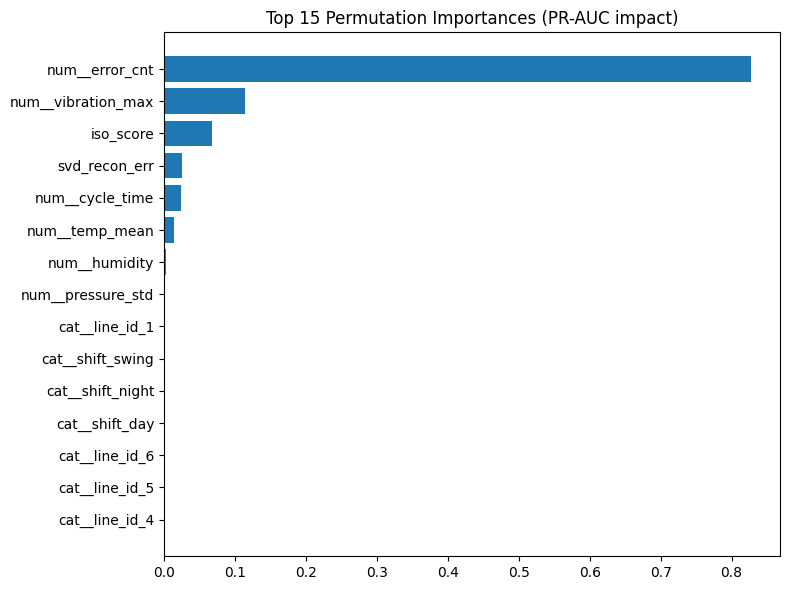

In [15]:
plt.figure(figsize=(8,6))
topk = 15
plt.barh(imp_df.head(topk)["feature"][::-1], imp_df.head(topk)["importance"][::-1])
plt.title(f"Top {topk} Permutation Importances (PR-AUC impact)")
plt.tight_layout()
plt.show()


## 13) 실무 엔지니어 플레이북: “데이터가 어떻다면 무엇을 선택?”

아래는 시험장에서 데이터를 보고 바로 적용할 수 있는 체크리스트입니다.

### A. 결측치가 많다
- (기본) `SimpleImputer`로 대체  
- 결측이 **의미 있는 이벤트**(센서 고장/라인 다운)라면:
  - 결측 indicator를 추가하는 것이 유리할 수 있음(옵션: `MissingIndicator` / 또는 `isna()`로 flag 컬럼 생성)

### B. 이상치가 많다(극단값)
- `RobustScaler`로 변경  
- `log1p` 변환(카운트/양수 heavy-tail 변수)  
- 트리 모델(RF/XGB)은 이상치에 비교적 강함 → 선형 모델보다 유리

### C. 범주형 카디널리티(종류)가 매우 많다
- OneHot이 너무 커져 메모리 이슈가 나면:
  - 희귀 카테고리 묶기(빈도 하위는 "OTHER")  
  - 또는 SVD 차원 축소를 적극 활용(이미 템플릿에 포함)

### D. 불균형이 매우 심하다(양성 < 1%)
- 지표: PR-AUC, Recall 중심
- 모델: XGB + `scale_pos_weight` / Logistic `class_weight`
- 임계값 정책: **Recall 고정** 또는 Top-N(현장 리소스 기반)
- (가능하면) 양성에 민감한 학습: threshold 낮추기

### E. 지도 모델 성능이 약하다
- 비지도 score를 반드시 피처로 추가(iso/svd)
- RF/XGB 같은 비선형 모델로 전환
- SVD 차원(svd_dim) 8~20 탐색
- 상호작용 피처(예: vib×error) 추가(선택)

### F. 비지도만 잘 되고 지도 모델이 불안정하다
- 라벨 노이즈가 있거나 양성이 너무 적을 수 있음  
- 운영 정책을 Top-N 중심으로 설계하고, 비지도 score를 더 크게 반영한 앙상블 사용

### G. 임계값 정책을 어떻게 고르나?
- **놓치면 큰 사고**: Recall 고정(≥0.90 같은)  
- **오탐 비용이 크다**: Precision 중심(Top 3% 등)  
- **균형이 목표**: F1 최적

---

## 14) 시험장에서 복붙 시 “바꾸는 곳”
1) `CSV_PATH` + `pd.read_csv()` (토이데이터 대신)  
2) `target_col`, `cat_cols`, `num_cols`  
3) (선택) `USE_ROBUST`, `svd_dim`, 정책 Top-N%, TARGET_RECALL  
4) (선택) 지도 모델: LR만/ RF만 / XGB까지
